In [1]:
import pandas as pd
import pymongo
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='NanumBarunGothic') # 혹은 다른 설치한 Nanum 폰트 사용
import scipy
import scipy.stats as stats

client=pymongo.MongoClient("192.168.10.240",27017)
db= client['AI_LKJ']
collection_tour_pass_review = db['data_tour_pass_review']
data_tour_pass_review = collection_tour_pass_review.find()
df_tour_pass_review = pd.DataFrame(data_tour_pass_review)
collection_tour_pass_review_tmon = db['data_tour_pass_review_tmon']
data_tour_pass_review_tmon = collection_tour_pass_review_tmon.find()
df_tour_pass_review_tmon = pd.DataFrame(data_tour_pass_review_tmon)

## 데이터 확인 및 전처리

In [2]:
df_review = pd.concat(objs=[df_tour_pass_review,df_tour_pass_review_tmon])
df_review.head()

,_id,title,region,rating,date,content
0,663dea3806635b047a688c55,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.03.24.,남편과 갑작스럽게 가게 된 여수여행 둘다 여수는 처음이라 어디를 가야할지 무엇을 해...
1,663dea3806635b047a688c56,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,4,24.04.29.,저렴한 가격에 여러군데 둘러 볼수있어 좋았어요.\n다만 문을 일찍 닫거나 영업시간이...
2,663dea3806635b047a688c57,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.04.24.,아이들과함께 즐거운 여행하고 왔습니다. 사진보시면 어디어디 갔는지 알수있구요. 1...
3,663dea3806635b047a688c58,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.04.15.,아주 좋네요\n김경오파티쓰리에서 바다보며 아아 한잔 하고요...그닥 친절하진 않았어...
4,663dea3806635b047a688c59,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.05.02.,처음 이용해보았는데 가성비좋은것같습니다. 주말에이용하는데 체험하고 활동하는것은 주말...


In [3]:
# 결측치 확인
df_review.isnull().sum()

_id        0
title      0
region     0
rating     0
date       0
content    5
dtype: int64

In [4]:
# 결측치 제거
df_review = df_review.dropna()
df_review.isnull().sum()

_id        0
title      0
region     0
rating     0
date       0
content    0
dtype: int64

In [5]:
import re

def remove_initial_and_vowel(text):
    # 초성과 모음을 제거하는 정규표현식
    pattern = re.compile("[ㄱ-ㅎ|ㅏ-ㅣ]+")  # ㄱ부터 ㅎ까지의 문자와 ㅏ부터 ㅣ까지의 문자를 모두 제거
    result = pattern.sub("", text)  # 정규표현식에 매칭되는 부분을 제거
    return result

In [6]:
from konlpy.tag import Okt
okt = Okt()

def remove_stopwords(text, stopwords):
    result = [word for word in text if word not in stopwords]
    return result

# 조사, 어미 구두점 같은 것을 제거 함수 / 나중에 불용어 처리 함수도 작성해주는 것이 좋음
def okt_clean(text):
    clean_text = []
    for word in okt.pos(text, stem=True):
        if word[1] not in ['Josa', 'Eomi', 'Punctuation','Determiner','Conjunction','Verb','Adjective','Adverb']:
            clean_text.append(word[0])
    # 불용어 처리
    stopwords = ['가', '고', '을', '를', '이', '는', 'n']  # 불용어 리스트
    clean_text = remove_stopwords(clean_text, stopwords)
    return " ".join(clean_text)

In [7]:
df_review["content"] = df_review["content"].apply(remove_initial_and_vowel)
df_review["content"] = df_review["content"].apply(okt_clean)
df_review["content"]

0       남편 가게 여수 여행 여수 처음 어디 가야 무엇 발견 여 수 투어 패스 덕분 여행 ...
1       가격 여러 군데 다만 문 일찍 영업 시간 제대로 표기 헛걸음 곳 좀 여러 명 경우 ...
2       아이 들 여행 사진 보시 어디 어디 11 곳 하나 사진 커서 안 곳 그냥 순천 48...
3       아주 김경 오 파티 바다 아아 한잔 그닥 여기저기 구경 아이스크림 옥 아이스크림 투...
4       처음 이용 가성 비 것 주말 에이 체험 활동 주말 용이 시간 좀 카페 쿠키 테디베어...
                              ...                        
1040                                                매장 커피
1041                                                  습 딘
1042                                     향 테마 파크 운영 안 웟 네
1043                                               럄 하 이용
1044                                                     
Name: content, Length: 28822, dtype: object

In [8]:
def datetime(text):
    text = text.replace('.', '')
    date = pd.to_datetime(text, format='%y%m%d')
    return date
df_review["datetime"] = df_review['date'].apply(datetime)
df_review

,_id,title,region,rating,date,content,datetime
0,663dea3806635b047a688c55,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.03.24.,남편 가게 여수 여행 여수 처음 어디 가야 무엇 발견 여 수 투어 패스 덕분 여행 ...,2024-03-24
1,663dea3806635b047a688c56,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,4,24.04.29.,가격 여러 군데 다만 문 일찍 영업 시간 제대로 표기 헛걸음 곳 좀 여러 명 경우 ...,2024-04-29
2,663dea3806635b047a688c57,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.04.24.,아이 들 여행 사진 보시 어디 어디 11 곳 하나 사진 커서 안 곳 그냥 순천 48...,2024-04-24
3,663dea3806635b047a688c58,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.04.15.,아주 김경 오 파티 바다 아아 한잔 그닥 여기저기 구경 아이스크림 옥 아이스크림 투...,2024-04-15
4,663dea3806635b047a688c59,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.05.02.,처음 이용 가성 비 것 주말 에이 체험 활동 주말 용이 시간 좀 카페 쿠키 테디베어...,2024-05-02
...,...,...,...,...,...,...,...
1040,663edc33cf0309091221da84,"[강원] 강릉제로패스\n하슬라아트월드,선교장 무료입장",강원,5,24.04.25.,매장 커피,2024-04-25
1041,663edc33cf0309091221da85,"[강원] 강릉제로패스\n하슬라아트월드,선교장 무료입장",강원,5,24.04.18.,습 딘,2024-04-18
1042,663edc6111e8110b348ba7de,[주말에어디가] 전북투어패스\n남원춘향여행권,전북,5,24.03.24.,향 테마 파크 운영 안 웟 네,2024-03-24
1043,663edc6111e8110b348ba7df,[주말에어디가] 전북투어패스\n남원춘향여행권,전북,5,24.03.07.,럄 하 이용,2024-03-07


## 연도별 투어패스 빈도수 분석

In [9]:
# 투어패스 연도별 빈도수
df_review["datetime"].dt.year.value_counts()

datetime
2022    10939
2023    10409
2024     3783
2021     3691
Name: count, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


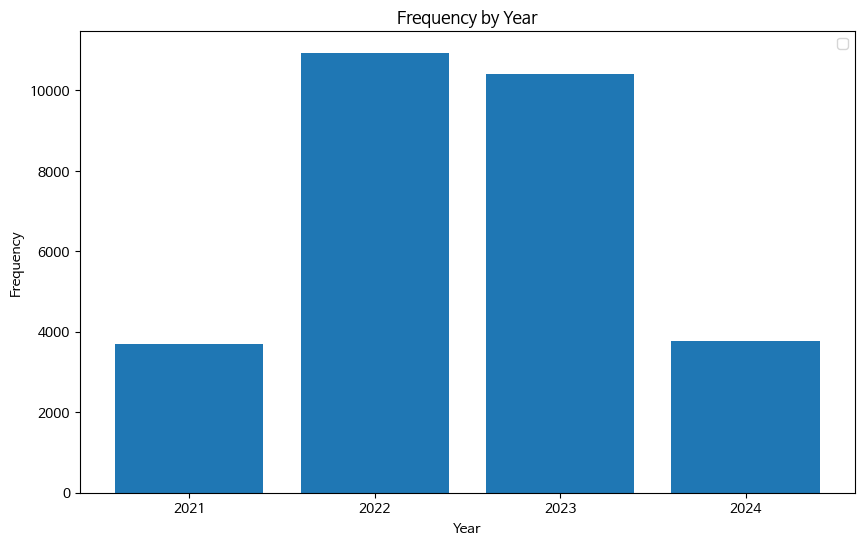

In [10]:
x = ["2021","2022","2023","2024"]
y = [len(df_review[df_review['datetime'].dt.year == 2021]),len(df_review[df_review['datetime'].dt.year == 2022]),len(df_review[df_review['datetime'].dt.year == 2023]),len(df_review[df_review['datetime'].dt.year == 2024])]
plt.figure(figsize=(10, 6))
plt.bar(x, y) 
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency by Year')
plt.legend() #범례
plt.show()

## 연도별 감성분석

### 2021년

In [12]:
df_review

,_id,title,region,rating,date,content,datetime
0,663dea3806635b047a688c55,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.03.24.,남편 가게 여수 여행 여수 처음 어디 가야 무엇 발견 여 수 투어 패스 덕분 여행 ...,2024-03-24
1,663dea3806635b047a688c56,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,4,24.04.29.,가격 여러 군데 다만 문 일찍 영업 시간 제대로 표기 헛걸음 곳 좀 여러 명 경우 ...,2024-04-29
2,663dea3806635b047a688c57,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.04.24.,아이 들 여행 사진 보시 어디 어디 11 곳 하나 사진 커서 안 곳 그냥 순천 48...,2024-04-24
3,663dea3806635b047a688c58,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.04.15.,아주 김경 오 파티 바다 아아 한잔 그닥 여기저기 구경 아이스크림 옥 아이스크림 투...,2024-04-15
4,663dea3806635b047a688c59,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.05.02.,처음 이용 가성 비 것 주말 에이 체험 활동 주말 용이 시간 좀 카페 쿠키 테디베어...,2024-05-02
...,...,...,...,...,...,...,...
1040,663edc33cf0309091221da84,"[강원] 강릉제로패스\n하슬라아트월드,선교장 무료입장",강원,5,24.04.25.,매장 커피,2024-04-25
1041,663edc33cf0309091221da85,"[강원] 강릉제로패스\n하슬라아트월드,선교장 무료입장",강원,5,24.04.18.,습 딘,2024-04-18
1042,663edc6111e8110b348ba7de,[주말에어디가] 전북투어패스\n남원춘향여행권,전북,5,24.03.24.,향 테마 파크 운영 안 웟 네,2024-03-24
1043,663edc6111e8110b348ba7df,[주말에어디가] 전북투어패스\n남원춘향여행권,전북,5,24.03.07.,럄 하 이용,2024-03-07


### 2022년

### 2023년

### 2024년